# Deep Learning

## Assignment 2

### Question 1:
### RNN For Auto Regressive Models

For this part of the question, we are required to make an auto regressive model which generates 2000 samples and 2000 evaluation samples, after which we need to train an RNN on the above data generated by the autoregressive model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import sklearn
from torchmetrics.regression import R2Score

MAX_SEQ_LEN = 2000

Let us start by making a model which which generates data with the given rule
X(t) = 0.6X(t-1) - 0.5X(t-2) - 0.2X(t-3) + U(t)
Where is U(t) is unifomly distributed random numbers between 0 and 0.1.

In [3]:
def generate_samples(n):
    samples = torch.zeros(3,)

    for _ in range(n):
        next_value = 0.6*samples[-1] - 0.5*samples[-2] - 0.2*samples[-3] + np.random.uniform(0.0, 0.1) # Generating the next value
        samples = torch.cat((samples, torch.tensor([next_value])), dim = 0) # Concatanating it to the original tensor
    return samples[3:-1], samples[4:] # Returning the input which is starting with 0 going to the n-1 sample and the ground truth which is the samples gereated


In [4]:
X_eval, Y_eval = generate_samples(2001)
X_train, Y_train = generate_samples(2001)
X_train = X_train.view(2000, 1) # reshaping it to get (sequence_len, input_size)
Y_train = Y_train.view(2000, 1)
X_eval = X_eval.view(2000, 1)
Y_eval = Y_eval.view(2000, 1)

The next step is to make the RNN which is going to be trained on the data samples generated above.
This will be a simple implementation using the pytorch library as below.
The below architecture is described as below.
- Takes input sequence length 2000
- Batch size is 1
- Hidden layer size is taken as 3, as we need to predict 3 coefficient values.
- Finally, we add a linear layer, to get a single output.

In [5]:
class RNN(nn.Module):

    def __init__(self, num_layers, input_size=1, hidden_size=1):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers) # The RNN layers
        self.linear = nn.Linear(hidden_size, 1) # Linear layer

    def forward(self, x):
        if len(x) == MAX_SEQ_LEN:
            h0 = torch.zeros(self.num_layers, self.hidden_size) # Initialising the hidden state
            out, _ = self.rnn(x, h0)
            out = self.linear(out)

            return out

        else:
            return self.inference(x)

    def inference(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size)

        input = x
        output_sequence = []

        for _ in range(MAX_SEQ_LEN):
            out, hidden = self.rnn(input, h0)

            out = self.linear(out)

            output_sequence.append(out)

            input = out

            h0 = hidden
            
        return torch.tensor(output_sequence).view(MAX_SEQ_LEN, 1)




        

Let us now initialise the various hyperparameters before training the model. We will start by implementing the training procedure with just one hidden layer.

In [6]:
model = RNN(1, 1, 3) # Taking hidden size to be 3 as there are 3 coefficients to predict.

learning_rate = 0.05 
epochs = 100
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

Now we can begin the training process of the RNN, in the following manner. Upon training the model, we can plot the graph of MSE vs epoch below that.

In [7]:
Accuracies = []

for epoch in range(epochs):
    output = model(X_train)

    loss = criterion(output, Y_train)
    Accuracies.append(loss.item())

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if (epoch+1)%10 == 0:
        print(f'epoch number: {epoch+1} | Training loss: {loss.item():.7f}')

/home/vedansh/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch number: 10 | Training loss: 0.0025340
epoch number: 20 | Training loss: 0.0018018
epoch number: 30 | Training loss: 0.0017448
epoch number: 40 | Training loss: 0.0016923
epoch number: 50 | Training loss: 0.0015321
epoch number: 60 | Training loss: 0.0013604
epoch number: 70 | Training loss: 0.0011862
epoch number: 80 | Training loss: 0.0010420
epoch number: 90 | Training loss: 0.0009856
epoch number: 100 | Training loss: 0.0009630


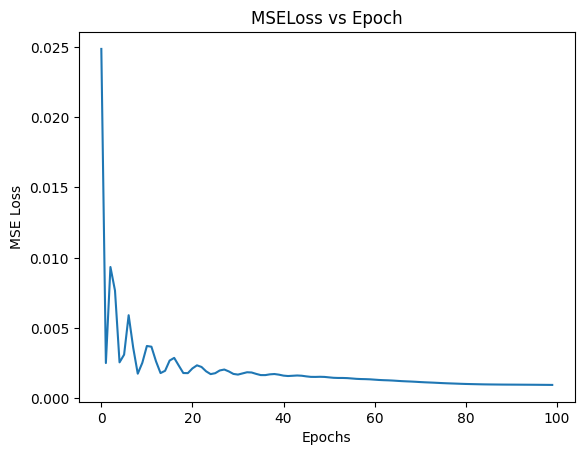

In [8]:
plt.plot(range(epochs), Accuracies)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('MSELoss vs Epoch')
plt.show()

Now let us compute the MSE, MAE and R_square loss on the test data.

In [9]:
with torch.no_grad():
    output = model(X_eval[0].repeat(1,1))
    
    MSE_criterion = nn.MSELoss()
    MAE_criterion = nn.L1Loss()
    Rsquare_criterion = R2Score()

    MSE_loss = MSE_criterion(output, Y_eval)
    MAE_loss = MAE_criterion(output, Y_eval)
    Rsquare_loss = Rsquare_criterion(output, Y_eval)

    print(f'MSE Loss : {MSE_loss.item():.4f}')
    print(f'MAE Loss : {MAE_loss.item():.4f}')
    print(f'R square Loss : {Rsquare_loss.item():.4f}')

    print('--------------------------')
    print(f'Ground Truth : {Y_eval[:5].T}')
    print(f'Predictions : {output[:5].T}')

MSE Loss : 0.0021
MAE Loss : 0.0368
R square Loss : -0.0004
--------------------------
Ground Truth : tensor([[0.0601, 0.1155, 0.0841, 0.0392, 0.0064]])
Predictions : tensor([[-0.0118,  0.0824,  0.1070,  0.0557,  0.0071]])


Now let us observe how this network works with 2 layers of RNN in it.

In [72]:
model = RNN(2, 1, 3) # Taking hidden size to be 3 as there are 3 coefficients to predict.

learning_rate = 0.1
epochs = 100
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

In [49]:
Accuracies = []

for epoch in range(epochs):
    output = model(X_train)

    loss = criterion(output, Y_train)
    Accuracies.append(loss.item())

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if (epoch+1)%10 == 0:
        print(f'epoch number: {epoch+1} | Training loss: {loss.item():.7f}')

epoch number: 10 | Training loss: 0.0028052
epoch number: 20 | Training loss: 0.0036396
epoch number: 30 | Training loss: 0.0026612
epoch number: 40 | Training loss: 0.0018266
epoch number: 50 | Training loss: 0.0018167
epoch number: 60 | Training loss: 0.0017674
epoch number: 70 | Training loss: 0.0016857
epoch number: 80 | Training loss: 0.0015992
epoch number: 90 | Training loss: 0.0014833
epoch number: 100 | Training loss: 0.0013464


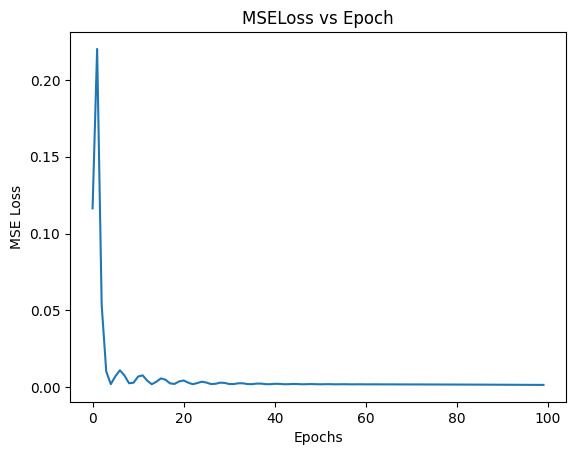

In [50]:
plt.plot(range(epochs), Accuracies)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('MSELoss vs Epoch')
plt.show()

In [51]:
with torch.no_grad():
    output = model(X_eval[0].repeat(1,1))
    
    MSE_criterion = nn.MSELoss()
    MAE_criterion = nn.L1Loss()
    Rsquare_criterion = R2Score()

    MSE_loss = MSE_criterion(output, Y_eval)
    MAE_loss = MAE_criterion(output, Y_eval)
    Rsquare_loss = Rsquare_criterion(output, Y_eval)

    print(f'MSE Loss : {MSE_loss.item():.4f}')
    print(f'MAE Loss : {MAE_loss.item():.4f}')
    print(f'R square Loss : {Rsquare_loss.item():.4f}')

    print('--------------------------')
    print(f'Ground Truth : {Y_eval[:5].T}')
    print(f'Predictions : {output[:5].T}')

MSE Loss : 0.0019
MAE Loss : 0.0352
R square Loss : -0.0485
--------------------------
Ground Truth : tensor([[ 0.1209,  0.0451, -0.0025, -0.0482,  0.0094]])
Predictions : tensor([[-0.2573,  0.0840, -0.0254,  0.1209,  0.0465]])


Having 2 layers makes it perform a little poorly than with 1 layer. Let us now observe this with 3 RNN ayers.

In [52]:
model = RNN(3, 1, 3) # Taking hidden size to be 3 as there are 3 coefficients to predict.

learning_rate = 0.1
epochs = 100
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

In [53]:
Accuracies = []

for epoch in range(epochs):
    output = model(X_train)

    loss = criterion(output, Y_train)
    Accuracies.append(loss.item())

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if (epoch+1)%10 == 0:
        print(f'epoch number: {epoch+1} | Training loss: {loss.item():.7f}')

epoch number: 10 | Training loss: 0.0111504
epoch number: 20 | Training loss: 0.0018594
epoch number: 30 | Training loss: 0.0027924
epoch number: 40 | Training loss: 0.0018609
epoch number: 50 | Training loss: 0.0019635
epoch number: 60 | Training loss: 0.0018513
epoch number: 70 | Training loss: 0.0018207
epoch number: 80 | Training loss: 0.0018169
epoch number: 90 | Training loss: 0.0018162
epoch number: 100 | Training loss: 0.0018153


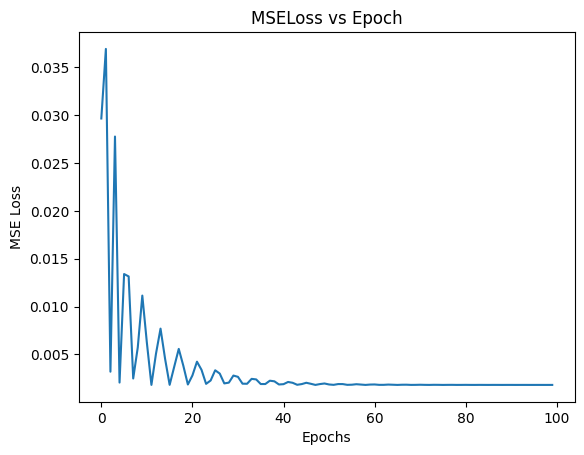

In [54]:
plt.plot(range(epochs), Accuracies)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('MSELoss vs Epoch')
plt.show()

In [55]:
with torch.no_grad():
    output = model(X_eval[0].repeat(1,1))
    
    MSE_criterion = nn.MSELoss()
    MAE_criterion = nn.L1Loss()
    Rsquare_criterion = R2Score()

    MSE_loss = MSE_criterion(output, Y_eval)
    MAE_loss = MAE_criterion(output, Y_eval)
    Rsquare_loss = Rsquare_criterion(output, Y_eval)

    print(f'MSE Loss : {MSE_loss.item():.4f}')
    print(f'MAE Loss : {MAE_loss.item():.4f}')
    print(f'R square Loss : {Rsquare_loss.item():.4f}')

    print('--------------------------')
    print(f'Ground Truth : {Y_eval[:5].T}')
    print(f'Predictions : {output[:5].T}')

MSE Loss : 0.0019
MAE Loss : 0.0350
R square Loss : -0.0027
--------------------------
Ground Truth : tensor([[ 0.1209,  0.0451, -0.0025, -0.0482,  0.0094]])
Predictions : tensor([[0.0506, 0.0509, 0.0455, 0.0491, 0.0459]])


As we can observe, the model does worse when there are 3 RNN layers used for the prediction.